In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import accuracy_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import CategoricalNB, GaussianNB, MultinomialNB
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

In [2]:
titanic = pd.read_csv("titanic.csv")
titanic.index = titanic.PassengerId
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,,
1,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
titanic.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

## Use the titanic data set, perform preprocessing by deal with missing values, drop irrelevant attributes.

In [4]:
titanic['Age'] = titanic['Age'].fillna(titanic.Age.median())
titanic['Embarked'] = titanic['Embarked'].fillna(titanic.Embarked.mode()[0])
titanic = titanic.replace(['male','female'],[0,1])
titanic = titanic.replace(['S','C','Q'], [1,2,3])
titanic.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
dtype: int64

In [5]:
titanic_cleaned = titanic.drop(axis=1, labels = ['Ticket','Cabin','PassengerId','Fare', 'Name'])

In [6]:
titanic_cleaned.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Embarked
PassengerId,,,,,,,
1,0,3,0,22.0,1,0,1
2,1,1,1,38.0,1,0,2
3,1,3,1,26.0,0,0,1
4,1,1,1,35.0,1,0,1
5,0,3,0,35.0,0,0,1


In [7]:
Y = np.array(titanic_cleaned['Survived'])
X = np.array(titanic_cleaned.iloc[:,1:])
print('X.shape = {}\nY.shape = {}'.format(X.shape,Y.shape))
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.3)

X.shape = (891, 6)
Y.shape = (891,)


In [8]:
print(X_test)

[[ 1.  0. 44.  2.  0.  3.]
 [ 2.  0. 52.  0.  0.  1.]
 [ 3.  1. 28.  1.  0.  3.]
 ...
 [ 3.  1. 30.  0.  0.  1.]
 [ 3.  1. 27.  0.  0.  1.]
 [ 1.  1. 19.  0.  2.  1.]]


## Perform Bayes classification using cross validation

In [9]:
pipe = Pipeline(steps= [('scaler', StandardScaler()), ('ohe', OneHotEncoder(handle_unknown = 'ignore')), ('mnb', MultinomialNB())]).fit(X_train, Y_train)

In [10]:
Y_pred = pipe.predict(X_test)

In [11]:
accuracy = accuracy_score(Y_pred, Y_test)
print("Accuracy = ", accuracy)

Accuracy =  0.753731343283582


In [12]:
pipe.score(X_test,Y_test)

0.753731343283582

In [13]:
crossval = cross_validate(pipe, X_train, Y_train, cv = 10)
print(crossval['test_score'])

[0.80952381 0.77777778 0.77777778 0.80645161 0.70967742 0.70967742
 0.80645161 0.83870968 0.83870968 0.77419355]


## Tabulate using relevant measures of accuracy , Sensitivity and specificity.

In [14]:
print(pipe.classes_)

[0 1]


In [15]:
cf_matrix = confusion_matrix(Y_test,Y_pred)
cf_matrix

array([[140,  30],
       [ 36,  62]])

<Figure size 720x360 with 0 Axes>

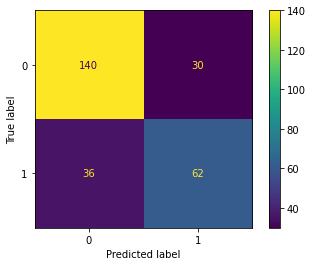

In [16]:
plt.figure(figsize = (10,5))
disp = ConfusionMatrixDisplay(confusion_matrix = cf_matrix, display_labels = pipe.classes_)
disp.plot()
plt.show()

In [17]:
TN = cf_matrix[0,0]
TP = cf_matrix[1,1]
FP = cf_matrix[0,1]
FN = cf_matrix[1,0]

TPR = TP / (TP+FN)
TNR = TN / (TN+FP)
Accuracy = (TP+TN) / (TP+TN+FP+FN)

print("Sensitivity = ", TPR)
print("Specificity = ", TNR)
print("Accuracy = ", Accuracy)

Sensitivity =  0.6326530612244898
Specificity =  0.8235294117647058
Accuracy =  0.753731343283582


## Visualize the ROC curve and comment on performance

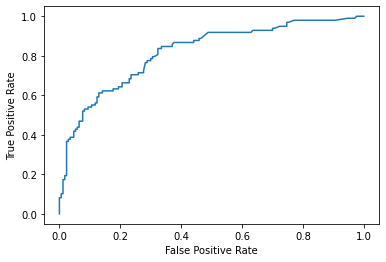

In [19]:
Y_pred_proba = pipe.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(Y_test, Y_pred_proba)
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### The model has a fairly accurate performance overall as it has a CV score of nearly 78%. Also the ROC Curve is almost reaching the value of 1 which means that the model is good at classification of the data.